In [1]:
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.cosmo_loader import  kids450_files_cluster, regr_Kids450
from my_utils.cosmo_collate import cosmotrain_collate_fn
from torch.utils.data import Dataset, DataLoader
#from my_utils.models import Regression_model, Regression_model_2
from torchvision import datasets, transforms, models

In [2]:
import torchsummary
#print(torchsummary.__version__)

In [3]:
import sys
print(sys.path)

['/python', '', '/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python311.zip', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/lib-dynload', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages']


In [4]:
from my_utils.real_resnets import Resnet_regressionmodel, Resnet_pretrainingmodel, DSModel
from my_utils.models import custom_pretrainingmodel, custom_DSModel, custom_Regression_model

In [5]:
#from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.cosmo_loader import  kids450_files_cluster, regr_Kids450
from my_utils.cosmo_collate import cosmotrain_collate_fn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from scipy.spatial import ConvexHull
import pickle
import matplotlib.animation as animation
#import IPython
#from IPython.display import HTML
#%matplotlib notebook

In [6]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

GPU is available.


In [7]:
#file_paths
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128
train_data = regr_Kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = regr_Kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  regr_Kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)

print(f'Length of test data: {len(test_data)}')

Length of test data: 114000


In [9]:
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    
    return model_files
def get_truegrid():
    truegrid_array = torch.empty((57,2))
    for i, file in tqdm(enumerate(file_paths_test), desc="Processing files"):
        with h5py.File(file, 'r') as file:
            
            #get the labels from the h5 file
            truegrid_array[i] = torch.tensor(file["labels"][0])
    return truegrid_array
#standardize
#get the statistics:
import pickle
def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

def data_stats_dict():
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict    
def un_standardize(omega_m, sigma_8):
    
    data_dict = data_stats_dict()
    mean_labels = data_dict["mean_labels"].numpy()
    std_dev_labels = data_dict["label_std_deviation"].numpy()
    
    
    omega_m = (omega_m * std_dev_labels[0]) + mean_labels[0]
    sigma_8 = (sigma_8 * std_dev_labels[1]) + mean_labels[1]
    
    return omega_m, sigma_8

def get_predictions(model, dataloader, device='cpu'):
    #set model to eval mode
    model.eval()
    true_values_omega_m = []
    true_values_sigma_8 = []
    pred_values_omega_m = []
    pred_values_sigma_8 = []
    with torch.no_grad():  # No need to compute gradients
        for i, (images,labels_true) in tqdm(enumerate(dataloader), desc="Processing data"):
            #print(i)
            images = images.squeeze().to(device).float()
            labels_true = labels_true.squeeze().to(device).float()
            labels_pred = model(images)
            
            pred_omega_m, pred_sigma_8 = labels_pred[:, 0], labels_pred[:, 1]
            true_omega_m, true_sigma_8 = labels_true[:, 0], labels_true[:, 1]
            
            true_values_omega_m.extend(true_omega_m.cpu().numpy())
            true_values_sigma_8.extend(true_sigma_8.cpu().numpy())
            pred_values_omega_m.extend(pred_omega_m.cpu().numpy())
            pred_values_sigma_8.extend(pred_sigma_8.cpu().numpy())
            #if i == 2:
            #    print("done")
            #    break
                
    return (np.array(true_values_omega_m), np.array(pred_values_omega_m)), \
           (np.array(true_values_sigma_8), np.array(pred_values_sigma_8))


#(true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)

In [10]:
def load_checkpoint(model,run_path,run_name):
    """
    Load the model
    Returns:
    model : PreModel : model
    optimizer : torch.optim.Optimizer : optimizer
    scheduler : torch.optim.lr_scheduler : scheduler
    """
    #load_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #run_name = "Kids_450_regrsimclr_full_test_epoch_100.pt"
    out = os.path.join(run_path ,run_name)
    checkpoint = torch.load(out)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [11]:
def run_inference(model, run_name,epochs):
    true_omega_m_list = []
    true_sigma_8_list = []
    pred_omega_m_list = []
    pred_sigma_8_list = []    
    #get model checkpoints
    model_checkpoints = get_model_checkpoints(run_name)
    run_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #print(model_checkpoints)
    for i,run_name in enumerate(model_checkpoints):
        model = load_checkpoint(model, run_path ,run_name)
        
        #get predictions
        (true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)
        #unstandardize the data
        unstd_pred_omega_m, unstd_pred_sigma_8 = un_standardize(pred_omega_m ,pred_sigma_8)
        
        true_omega_m_list.append(true_omega_m)
        pred_omega_m_list.append(unstd_pred_omega_m)
        true_sigma_8_list.append(true_sigma_8)
        pred_sigma_8_list.append(unstd_pred_sigma_8)
        
    return true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list

In [47]:
from torchviz import make_dot
import torch
x = torch.randn(1,4,128,128).to('cuda:0')
y = model(x)
dot = make_dot(y,params = dict(model.named_parameters()))
dot.render("model_architecture_test", format="png")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
print(f" Summary of the model: {summary(model, (4, 128, 128))}",flush=True)

In [56]:
# Export the model to ONNX
torch.onnx.export(model, x, "model.onnx", export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

In [54]:
import hiddenlayer as hl
x = torch.zeros([1,4,128,128]).to('cuda:0')
hl_graph = hl.build_graph(model, x )

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'

In [13]:
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_resnet_34_natural_images"
epochs = list(range(start_epoch,end_epoch+1))
model = Resnet_regressionmodel('resnet34',pretrained_weights = False,dropout_rate = 0.3,head_type = "nonlinear_dropout").to('cuda:0')
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Kids_450_resnet_34_natural_images


Processing data: 593it [00:32, 18.30it/s]
Processing data: 593it [00:31, 18.72it/s]
Processing data: 593it [00:31, 18.63it/s]
Processing data: 593it [00:31, 18.58it/s]
Processing data: 593it [00:31, 18.70it/s]
Processing data: 593it [00:31, 18.54it/s]
Processing data: 593it [00:31, 18.58it/s]
Processing data: 593it [00:32, 18.53it/s]
Processing data: 593it [00:32, 18.49it/s]
Processing data: 593it [00:32, 18.36it/s]
Processing data: 593it [00:32, 18.37it/s]
Processing data: 593it [00:32, 18.27it/s]
Processing data: 593it [00:32, 18.45it/s]
Processing data: 593it [00:32, 18.28it/s]
Processing data: 593it [00:32, 18.53it/s]
Processing data: 593it [00:32, 18.53it/s]
Processing data: 593it [00:31, 18.55it/s]
Processing data: 593it [00:32, 18.42it/s]
Processing data: 593it [00:31, 18.59it/s]
Processing data: 593it [00:31, 18.65it/s]
Processing data: 593it [00:32, 18.36it/s]


In [39]:
#the one with snall Lr and nonlinear head
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_real_resnet34_small"
epochs = list(range(start_epoch,end_epoch+1))
#model = Resnet_regressionmodel('resnet34',pretrained_weights = False ,head_type = "nonlinear").to('cuda:0')
model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear" ,hidden_channels= 128).to("cuda")

#model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear_dropout" ,hidden_channels= 128).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:29, 19.98it/s]
Processing data: 593it [00:29, 19.86it/s]
Processing data: 593it [00:30, 19.71it/s]
Processing data: 593it [00:31, 19.06it/s]
Processing data: 593it [00:30, 19.70it/s]
Processing data: 593it [00:30, 19.54it/s]
Processing data: 593it [00:30, 19.35it/s]
Processing data: 593it [00:31, 18.89it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.64it/s]
Processing data: 593it [00:30, 19.46it/s]
Processing data: 593it [00:30, 19.38it/s]
Processing data: 593it [00:30, 19.28it/s]
Processing data: 593it [00:30, 19.63it/s]
Processing data: 593it [00:30, 19.50it/s]
Processing data: 593it [00:30, 19.28it/s]
Processing data: 593it [00:31, 19.10it/s]
Processing data: 593it [00:30, 19.33it/s]
Processing data: 593it [00:30, 19.60it/s]
Processing data: 593it [00:30, 19.59it/s]
Processing data: 593it [00:29, 19.79it/s]


In [23]:
#the one with smaller channels and 
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_smaller_channels_dropout"
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear_dropout" ,hidden_channels= 128).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.73it/s]
Processing data: 593it [00:29, 20.03it/s]
Processing data: 593it [00:29, 19.87it/s]
Processing data: 593it [00:29, 19.78it/s]
Processing data: 593it [00:31, 18.79it/s]
Processing data: 593it [00:30, 19.55it/s]
Processing data: 593it [00:30, 19.61it/s]
Processing data: 593it [00:30, 19.54it/s]
Processing data: 593it [00:30, 19.46it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.47it/s]
Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:30, 19.14it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.35it/s]
Processing data: 593it [00:30, 19.56it/s]
Processing data: 593it [00:30, 19.68it/s]
Processing data: 593it [00:30, 19.34it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.48it/s]


In [ ]:
start_epoch = 1
end_epoch = 150
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2,1,1], head_type= "nonlinear",hidden_channels= 64 ).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

In [19]:
start_epoch = 1
end_epoch = 140
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2], head_type= "linear",hidden_channels= 256 ).to("cuda")
run_name = "Kids_450_new_build"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:24, 24.59it/s]
Processing data: 593it [00:24, 24.51it/s]
Processing data: 593it [00:26, 22.59it/s]
Processing data: 593it [00:24, 23.94it/s]
Processing data: 593it [00:24, 24.17it/s]
Processing data: 593it [00:24, 23.81it/s]
Processing data: 593it [00:25, 22.89it/s]
Processing data: 593it [00:25, 23.54it/s]
Processing data: 593it [00:25, 23.31it/s]
Processing data: 593it [00:25, 23.09it/s]
Processing data: 593it [00:24, 23.98it/s]
Processing data: 593it [00:26, 22.51it/s]
Processing data: 593it [00:24, 24.11it/s]


In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:00, 651.98it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


In [19]:
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

88000 90000


Processing files: 57it [00:00, 988.55it/s]


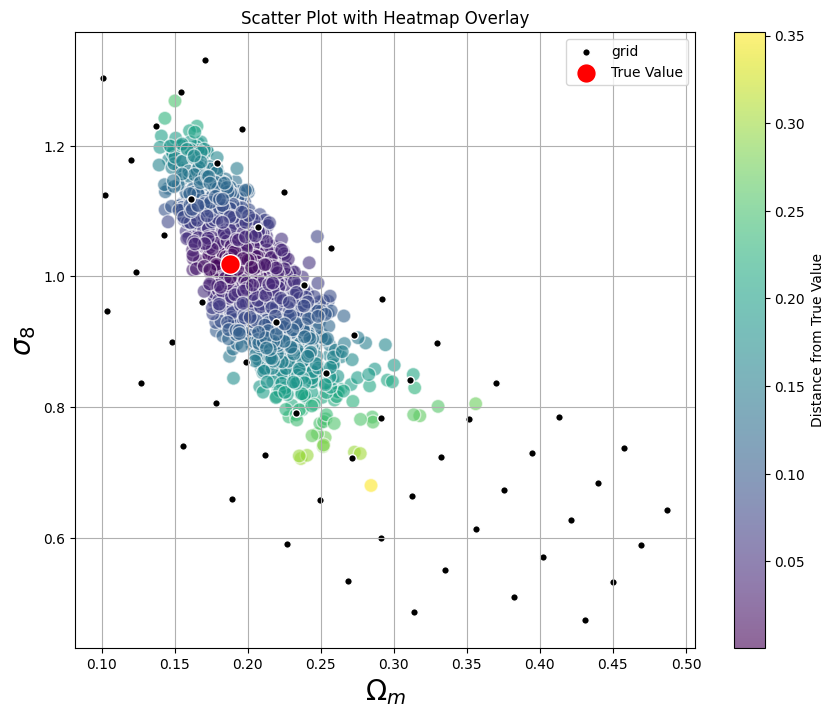

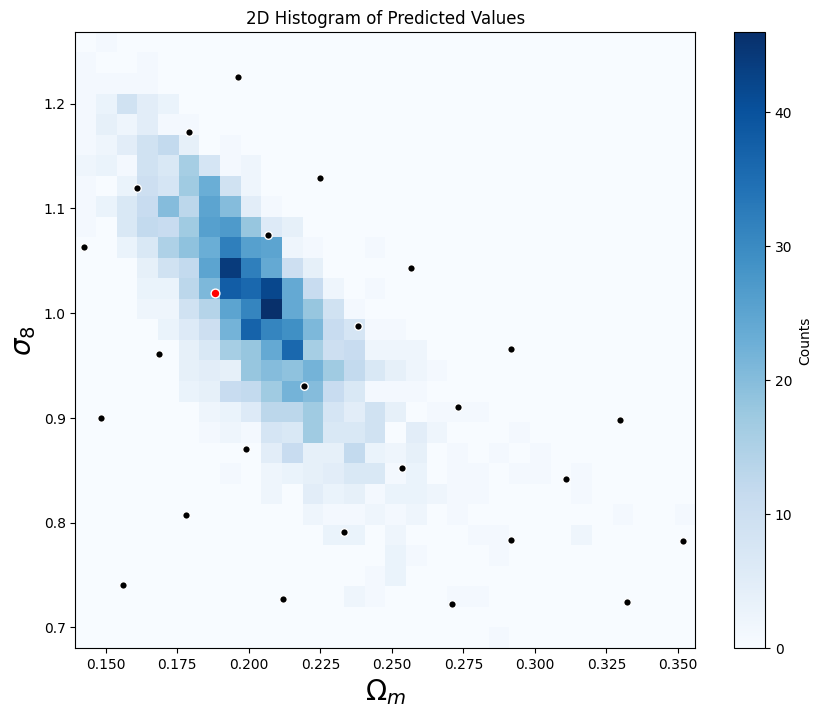

In [26]:
#in the test data every parameter is concurrent 2000 elements
epoch = 20
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

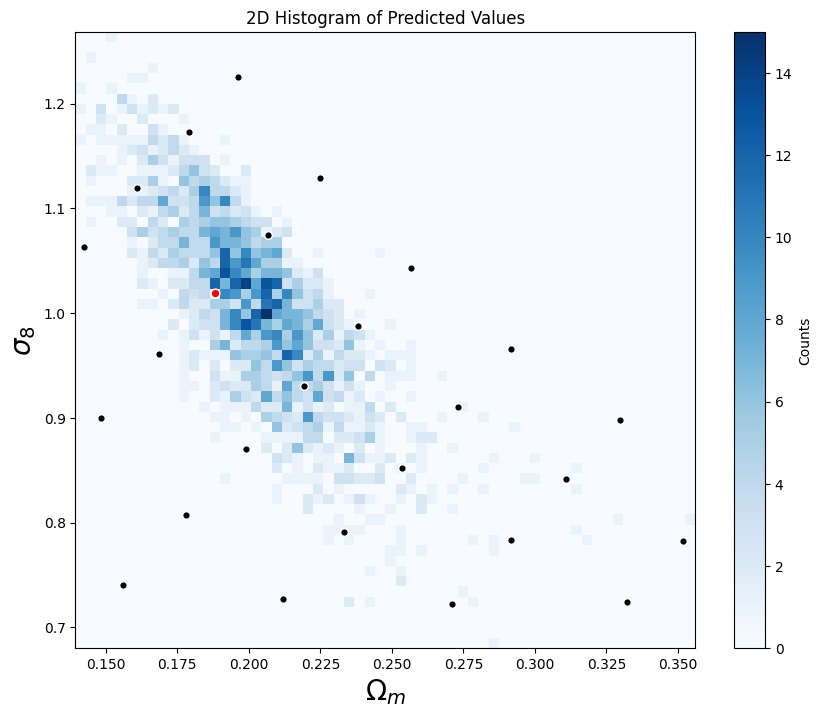

In [27]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

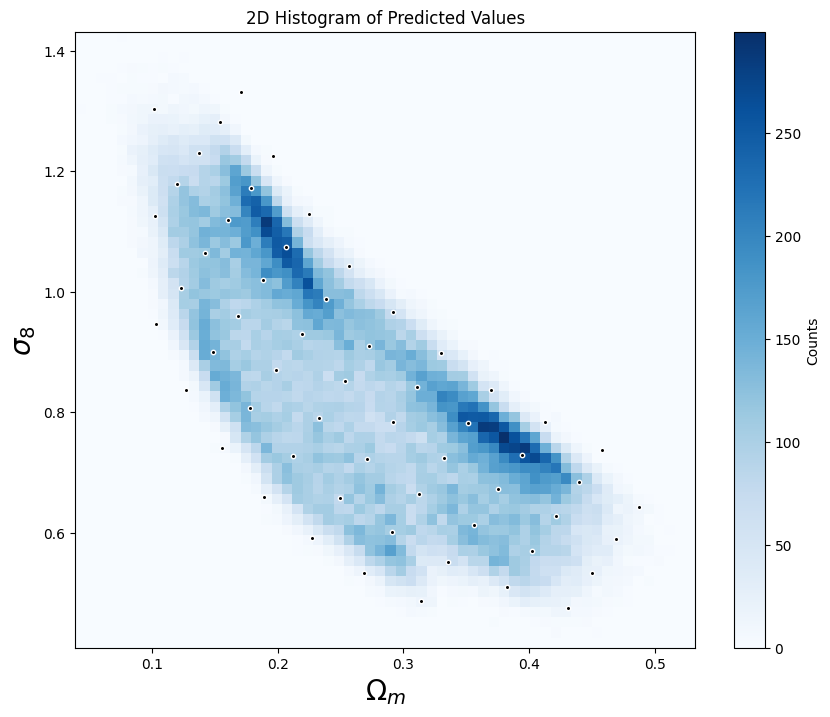

In [28]:
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=10, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)


plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

Processing files: 57it [00:00, 1004.51it/s]


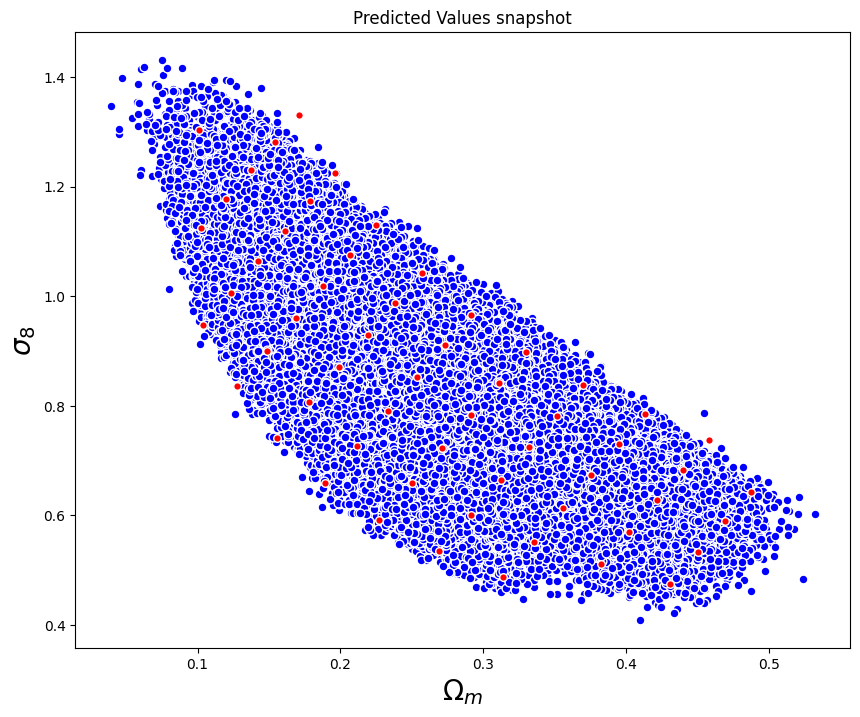

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale
plt.scatter(pred_omega_m, pred_sigma_8, c='blue', s=40, label='True Value', edgecolor='w')
plt.scatter(grid_omega_m, grid_sigma_8, c='red', s=30, label='grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('Predicted Values snapshot')

# Show plot
plt.show()

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 967.30it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


In [24]:
prices = [7,1,5,3,6,4]
prices.index(4)
len(prices)

6

In [12]:
print("hello")

hello


The plots for downstram model with pretraining. I have to load the whole set. First the pretraining part, then infuse it with downstream and then i can load the checkpoints.


In [ ]:
pretrained_model = Resnet_pretrainingmodel('resnet34_simclr',
                               pretrained_weights = False, #these are the resnet weights
                               dropout_rate = 0.2, 
                               head_type = "nonlinear").to('cuda:0')
model = DSModel(pretrained_model,
               base_model = "resnet34",
               dropout_rate = 0.2,
               head_type = "nonlinear_dropout").to('cuda:0')
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_ds_resnet34_random_weights_test"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

In [38]:
pretrained_model = custom_pretrainingmodel('custom_resnet_simclr',
                                   layers = [3, 4, 6, 3],
                                   dropout_rate = 0.3, 
                                   head_type = "nonlinear").to('cuda:0')
model = custom_DSModel(pretrained_model,
                   base_model = "custom_resnet",
                   dropout_rate = 0.3,
                   head_type = "nonlinear_dropout").to('cuda:0')  
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "custom_resnet_200_300_downstream"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

custom_resnet_200_300_downstream


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 60 worker processes in total. Our suggested max number of worker in current system is 19, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Processing data: 593it [00:34, 17.29it/s]
Processing data: 593it [00:29, 20.12it/s]
Processing data: 593it [00:28, 20.47it/s]
Processing data: 593it [00:29, 20.32it/s]
Processing data: 593it [00:29, 19.77it/s]
Processing data: 593it [00:30, 19.30it/s]
Processing data: 593it [00:29, 20.31it/s]
Processing data: 593it [00:30, 19.31it/s]
Processing data: 593it [00:31, 18.74it/s]
Processing data: 593it [00:30, 19.55it/s]
Processing data: 593it [00:29, 20.04it/s]
Processing data: 593

In [39]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:12,  4.71it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


In [40]:
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

88000 90000


Processing files: 57it [00:00, 651.34it/s]


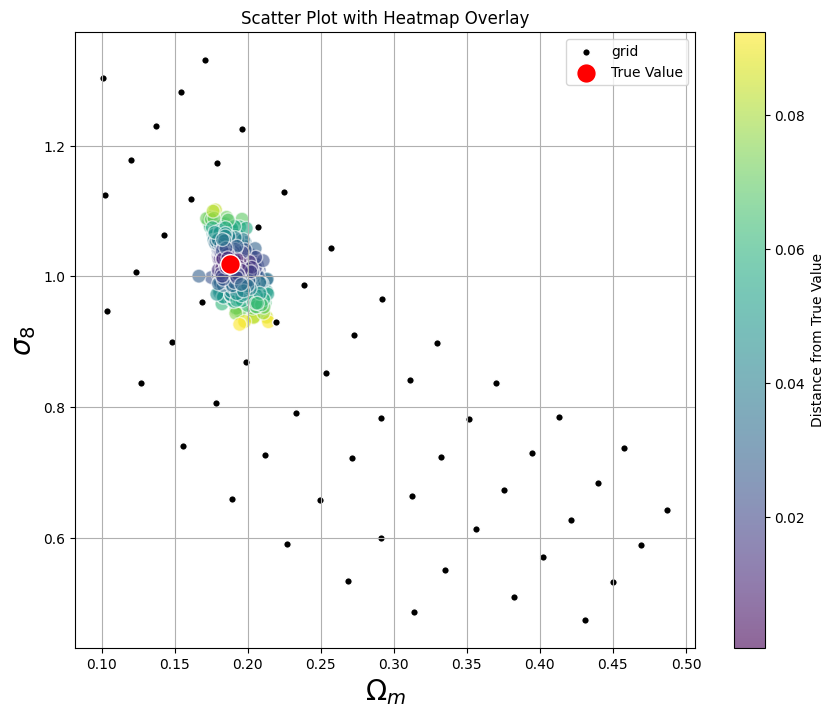

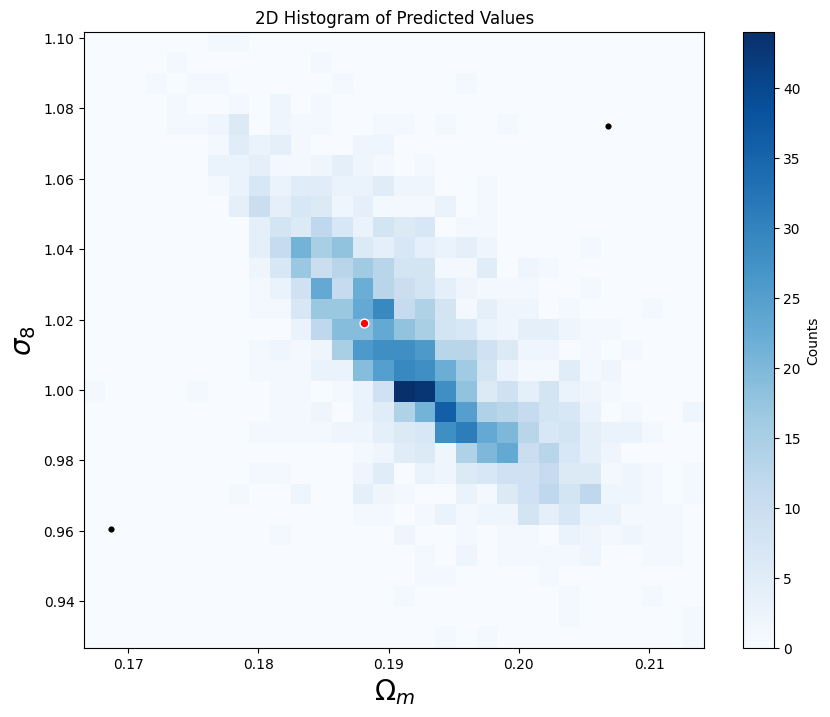

In [45]:
#in the test data every parameter is concurrent 2000 elements
#real epoch epoch * 5 if epoch == 1
epoch = 12
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

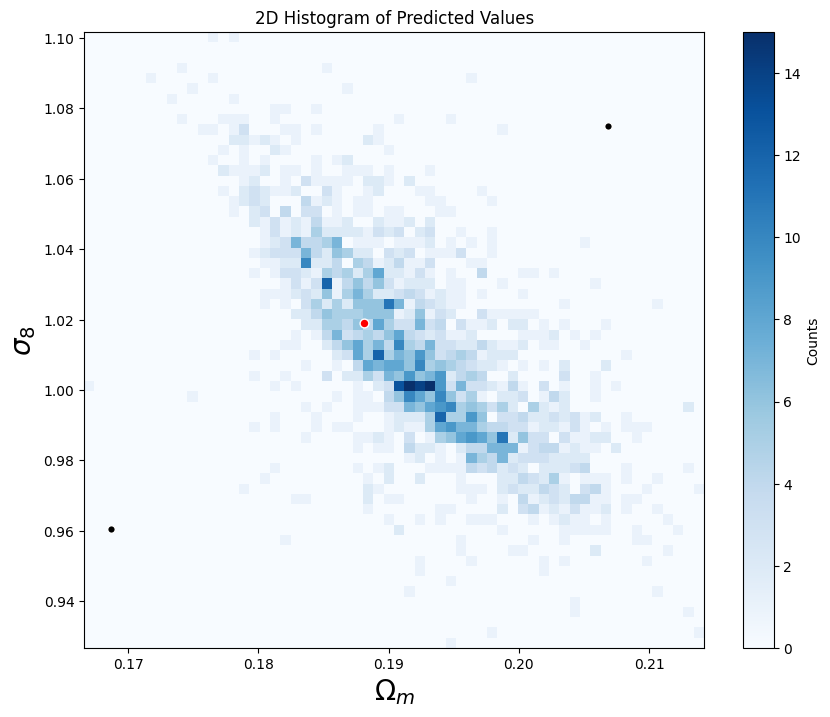

In [46]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

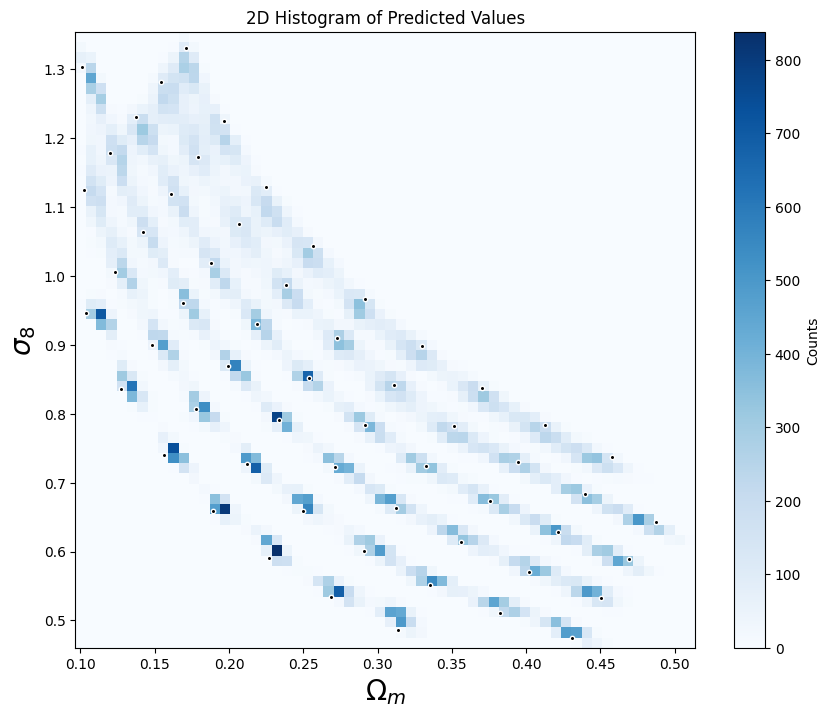

In [47]:
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=10, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)



plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

Processing files: 57it [00:00, 625.64it/s]


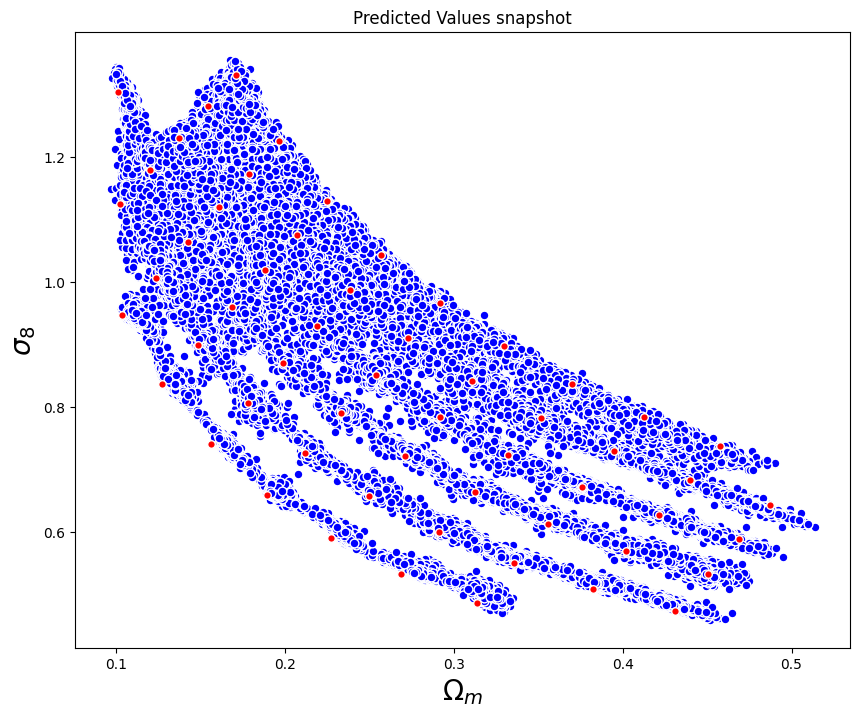

In [48]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale
plt.scatter(pred_omega_m, pred_sigma_8, c='blue', s=40, label='True Value', edgecolor='w')
plt.scatter(grid_omega_m, grid_sigma_8, c='red', s=30, label='grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('Predicted Values snapshot')

# Show plot
plt.show()

In [49]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 639.77it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


In [39]:
print("hello")

hello


In [11]:
def strStr(haystack: str, needle: str) -> int:
    needle_l = len(needle)
    haystack_l = len(haystack)
    print(needle_l, haystack_l)
    kernel_start = 0
    kernel_end = needle_l
    print(kernel_start,kernel_end,haystack_l)
    while kernel_start != haystack_l-needle_l+1:
        print(kernel_start,kernel_end,haystack_l)
        if haystack[kernel_start:kernel_end] ==  needle:
            print(f'obs: {haystack[kernel_start:kernel_end]}')
            return kernel_start
        kernel_start +=1
        kernel_end += 1
    return -1

In [12]:
strStr(haystack = "abb",needle = "c")

1 3
0 1 3
0 1 3
1 2 3
2 3 3
obs: c


2

In [53]:
def strStr(haystack: str, needle: str) -> int:
    needle_l = len(needle)
    haystack_l = len(haystack)
    #print(needle_l, haystack_l)
    kernel_start = 0
    kernel_end = needle_l
    if haystack == needle:
        return 0
    if haystack_l < needle_l:
        return -1
    print(kernel_start,kernel_end,haystack_l)
    #while kernel_end != haystack_l:
    range_end = haystack_l-kernel_end+1
    while kernel_start != range_end:
        if kernel_end> haystack_l+2:
            print("still")
            break
        print(range_end)
        print(kernel_start,kernel_end,haystack_l)
        if haystack[kernel_start:kernel_end] ==  needle:
            print(f'obs: {haystack[kernel_start:kernel_end]}')
            return kernel_start
        kernel_start +=1
        kernel_end += 1
    return -1

In [54]:
strStr(haystack = "leetcode",needle = "leeto")

0 5 8
4
0 5 8
4
1 6 8
4
2 7 8
4
3 8 8


-1